修論の手法の解析方法のサンプルファイル  
引き継ぎ用に作成  
このファイルを元にコピーして使うことを想定  
ほぼ最小構成


まずは各パッケージをインポート  
master_positioning は自作のモジュール  
他は普通に pip（正確には poetry でインストールした）


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import master_positioning as mpos

続いて図のスタイルを設定  
ここは発表だったり論文だったりに合わせて適宜変える


In [3]:
plt.style.use(["science", "notebook", "./slide.mplstyle"])

測位実験のときの真値を DataFrame で持っておく  
実験するときはデータのフォルダに真値を書いたファイルも入れとく  
csv が無難だと思う


In [4]:
df_true = pd.read_csv("../data/pos-reflect-1ms/measure-points.csv", index_col=0)

各方向ごとのスペクトルのデータベースを作成  
使う周波数帯変えるとかの場合は引数を与えて


In [5]:
db = mpos.CeilingTDoADB("../data/reference-reflect-1ms")

実験で録った音声データを読み込んで配列に入れる


In [6]:
test_signal = [
    mpos.readwav(f"../data/pos-reflect-1ms/p{i+28}.wav")[:, 1] for i in range(14)
]

各点で 100 回ずつ測位  
ここでやりやすくするために送信信号の 1 回分を切りの良い長さに設定している  
今回は信号長 2.5 秒なので、5 秒分あれば確実に 1 波形分含まれる  
だから 120000 サンプルずつずらしながら 240000 サンプル切り取れば 1 回分の測位になる  
それを 100 回 × 計測点数分


In [7]:
est = np.array(
    [
        [db.positioning(s[i * 120000 : (i + 2) * 120000]) for i in range(100)]
        for s in test_signal
    ]
)

真値を使いやすいように整形  
次の値を用意

- distance: スピーカーからの距離
- azimuth: 方位角
- elevation: 仰角
- v_distance: 天井反射の仮想スピーカーからの距離
- distance_diff: 実スピーカー、仮想スピーカーからの距離差
- sample_diff: 距離差をサンプル数で表したもの、TDoA の値


In [8]:
r, theta, phi = mpos.rect_to_polar_3d(df_true["x"], df_true["y"], df_true["z"] - 2.2)
df_true["distance"] = r
df_true["azimuth"] = theta
df_true["elevation"] = phi
v_distance, _, _ = mpos.rect_to_polar_3d(df_true["x"], df_true["y"], df_true["z"] - 2.8)
df_true["v_distance"] = v_distance
df_true["distance_diff"] = np.abs(df_true["distance"] - df_true["v_distance"])
df_true["sample_diff"] = (df_true["distance_diff"] / 340 * 48000).astype(int)
df_true

,x,y,z,distance,azimuth,elevation,v_distance,distance_diff,sample_diff
p28,-0.25,1.25,1.000,1.750714,-11.309932,43.830861,2.205675,0.454960,64
p29,0.25,1.25,1.000,1.750714,11.309932,43.830861,2.205675,0.454960,64
p30,-0.25,1.75,1.000,2.136586,-8.130102,34.438989,2.522895,0.386309,54
p31,0.25,1.75,1.000,2.136586,8.130102,34.438989,2.522895,0.386309,54
p32,-0.25,1.25,1.250,1.589811,-11.309932,37.234834,2.006863,0.417052,58
p33,0.25,1.25,1.250,1.589811,11.309932,37.234834,2.006863,0.417052,58
p34,-0.25,1.75,1.250,2.006863,-8.130102,28.495639,2.351064,0.344200,48
p35,0.25,1.75,1.250,2.006863,8.130102,28.495639,2.351064,0.344200,48
p36,-0.25,1.25,0.750,1.930673,-11.309932,49.236395,2.414022,0.483348,68
p37,0.25,1.25,0.750,1.930673,11.309932,49.236395,2.414022,0.483348,68


測位誤差を計算


In [9]:
pos_error = np.array(
    [
        [
            np.linalg.norm(est[i, j, 0:3] - df_true.iloc[i][["x", "y", "z"]].values)
            for j in range(100)
        ]
        for i in range(14)
    ]
)

方位角、仰角、TDoA 推定の誤差計算


In [10]:
azimuth_error = np.abs(est[:, :, 3] - df_true["azimuth"].to_numpy().reshape(-1, 1))
elevation_error = np.abs(est[:, :, 4] - df_true["elevation"].to_numpy().reshape(-1, 1))
tdoa_error = np.abs(est[:, :, 5] - df_true["sample_diff"].to_numpy().reshape(-1, 1))

得られた値を DataFrame に整理  
項目

- x, y, z, azimuth, elevation, tdoa: それぞれの推定値
- test: 計測点の番号
- position_error, azimuth_error, elevation_error, tdoa_error: それぞれの誤差


In [11]:
df_est = pd.DataFrame()
for i, d in enumerate(est):
    df_est = pd.concat(
        [
            df_est,
            pd.DataFrame(
                d, columns=["x", "y", "z", "azimuth", "elevation", "tdoa"]
            ).assign(test=i),
        ]
    ).reset_index(drop=True)
df_est["position_error"] = pos_error.reshape(-1)
df_est["azimuth_error"] = azimuth_error.reshape(-1)
df_est["elevation_error"] = elevation_error.reshape(-1)
df_est["tdoa_error"] = tdoa_error.reshape(-1)
df_est.head()

,x,y,z,azimuth,elevation,tdoa,test,position_error,azimuth_error,elevation_error,tdoa_error
0,-0.283255,1.136075,1.069320,-14.0,44.0,64.0,0,0.137441,2.690068,0.169139,0.0
1,-0.288840,1.158474,1.047026,-14.0,44.0,63.0,0,0.109986,2.690068,0.169139,1.0
2,-0.288840,1.158474,1.047026,-14.0,44.0,63.0,0,0.109986,2.690068,0.169139,1.0
3,-0.263385,1.140845,1.069320,-13.0,44.0,64.0,0,0.129997,1.690068,0.169139,0.0
4,-0.288840,1.158474,1.047026,-14.0,44.0,63.0,0,0.109986,2.690068,0.169139,1.0


測位点の真値をプロット


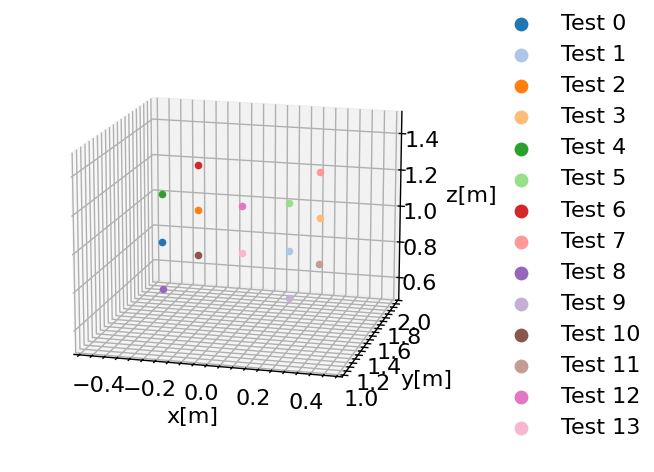

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
for i, row in enumerate(df_true[["x", "y", "z"]].to_numpy()):
    ax.scatter(
        row[0],
        row[1],
        row[2],
        label=f"Test {i}",
        color=sns.color_palette("tab20", 14)[int(i)],
        marker="o",
    )

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(1, 2)
ax.set_zlim(0.5, 1.5)
ax.set_xlabel("x[m]", labelpad=10)
ax.set_ylabel("y[m]", labelpad=15)
ax.set_zlabel("z[m]", labelpad=20)
ax.view_init(elev=15, azim=-75)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, markerscale=2)
ax.set_box_aspect(aspect=None, zoom=0.9)

全体の測位誤差の CDF をプロット


Text(90.44444444444441, 0.5, 'CDF')

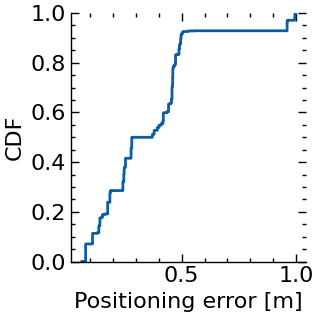

In [13]:
sns.displot(df_est, x="position_error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

各測位点ごとの測位誤差の CDF をプロット


Text(120.00071527777776, 0.5, 'CDF')

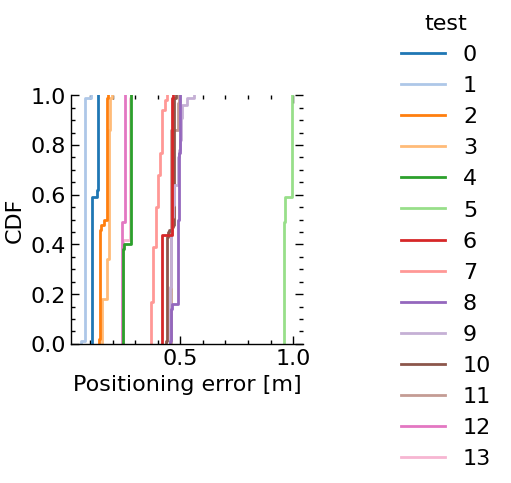

In [14]:
sns.displot(df_est, x="position_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

全体の方位角推定誤差の CDF をプロット


Text(90.44444444444441, 0.5, 'CDF')

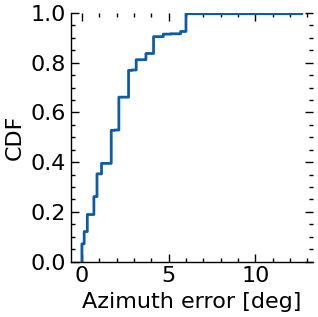

In [15]:
sns.displot(df_est, x="azimuth_error", kind="ecdf")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

各測位点ごとの方位角推定誤差の CDF をプロット


Text(120.00071527777776, 0.5, 'CDF')

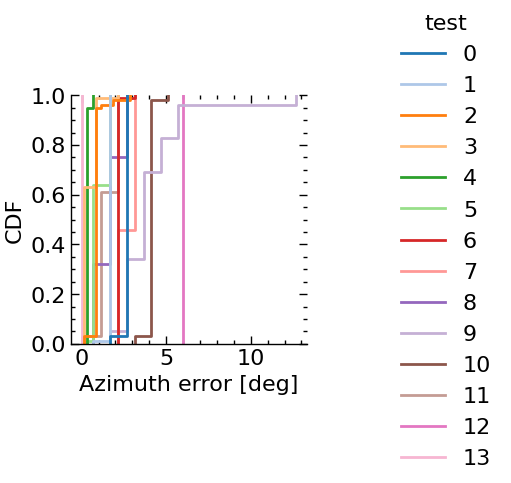

In [16]:
sns.displot(df_est, x="azimuth_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

測位点全体の仰角推定誤差の CDF をプロット


Text(90.44444444444441, 0.5, 'CDF')

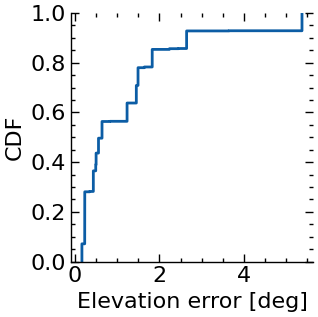

In [17]:
sns.displot(df_est, x="elevation_error", kind="ecdf")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

各測位点ごとの仰角推定誤差の CDF をプロット


Text(120.00071527777776, 0.5, 'CDF')

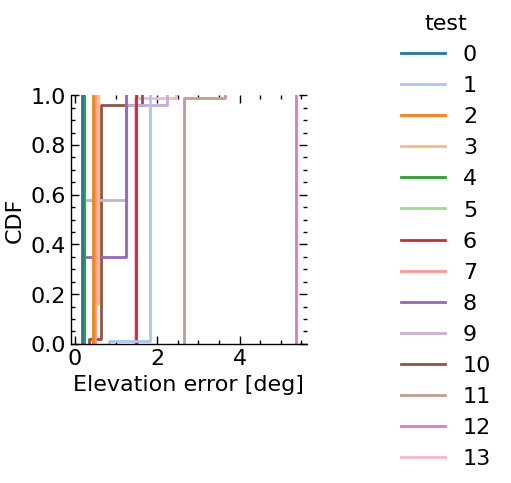

In [18]:
sns.displot(df_est, x="elevation_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

全体の方位角、仰角の CDf を重ねたもの


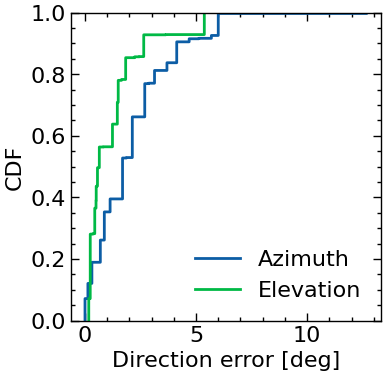

In [19]:
plt.figure(figsize=(4, 4))
sns.ecdfplot(df_est, x="azimuth_error", label="Azimuth")
sns.ecdfplot(df_est, x="elevation_error", label="Elevation")
plt.xlabel("Direction error [deg]")
plt.ylabel("CDF")
plt.legend()

全体の TDoA 推定誤差の CDF をプロット


Text(90.44444444444441, 0.5, 'CDF')

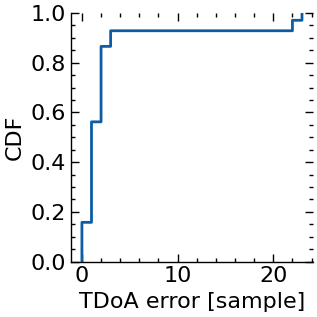

In [20]:
sns.displot(df_est, x="tdoa_error", kind="ecdf")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

各測位点ごとの TDoA 推定誤差の CDF をプロット


Text(120.00071527777776, 0.5, 'CDF')

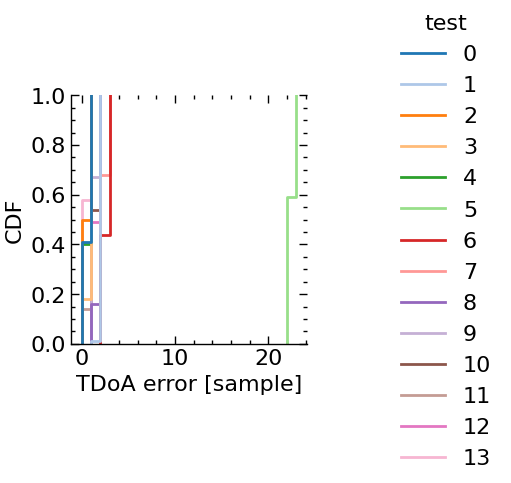

In [21]:
sns.displot(df_est, x="tdoa_error", kind="ecdf", hue="test", palette="tab20")
plt.xlabel("TDoA error [sample]")
plt.ylabel("CDF")

各推定誤差の 90, 50 パーセンタイルを出力


In [22]:
pos_err_90p = np.percentile(df_est["position_error"], 90)
pos_err_50p = np.percentile(df_est["position_error"], 50)
azimuth_err_90p = np.percentile(df_est["azimuth_error"], 90)
azimuth_err_50p = np.percentile(df_est["azimuth_error"], 50)
elevation_err_90p = np.percentile(df_est["elevation_error"], 90)
elevation_err_50p = np.percentile(df_est["elevation_error"], 50)
tdoa_err_90p = np.percentile(df_est["tdoa_error"], 90)
tdoa_err_50p = np.percentile(df_est["tdoa_error"], 50)
print(
    f"pos_err_90p: {pos_err_90p:.3f}, pos_err_50p: {pos_err_50p:.3f},  height_err_90p: {tdoa_err_90p:.3f}, height_err_50p: {tdoa_err_50p:.3f}"
)
print(
    f"azimuth_err_90p: {azimuth_err_90p}, azimuth_err_50p: {azimuth_err_50p}, elevation_err_90p: {elevation_err_90p}, elevation_err_50p: {elevation_err_50p}"
)

pos_err_90p: 0.497, pos_err_50p: 0.328,  height_err_90p: 3.000, height_err_50p: 1.000
azimuth_err_90p: 4.13010235415598, azimuth_err_50p: 1.6900675259797868, elevation_err_90p: 2.6441749571448128, elevation_err_50p: 0.6441749571448128


測位の解析は以上  
さらなる考察が必要な場合はこの後なり途中なりで適宜行う
